# Example of extracting table data from Microsoft PPT documents

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
import os
import sys
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
#%pip install ../../python/dist/spark-ocr-3.8.0+spark30.tar.gz

## Initialization of spark session

In [3]:
from sparkocr import start

spark = start(secret=secret, jar_path=spark_ocr_jar_path, nlp_version="3.2.1")

spark
spark.sparkContext.setLogLevel("ERROR")

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.8.0



## Import OCR transformers

In [9]:
from sparkocr.transformers import *
from sparkocr.utils import display_images, display_tables, display_pdf
from pyspark.sql.functions import collect_list,col

## Read PPT document as binary file

In [5]:
import pkg_resources
ppt_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/ppt/54111.ppt')
ppt_example_df = spark.read.format("binaryFile").load(ppt_example)

## Preview document using `PptToPdf` and `PdfToImage` transformers


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/ppt/54111.ppt
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


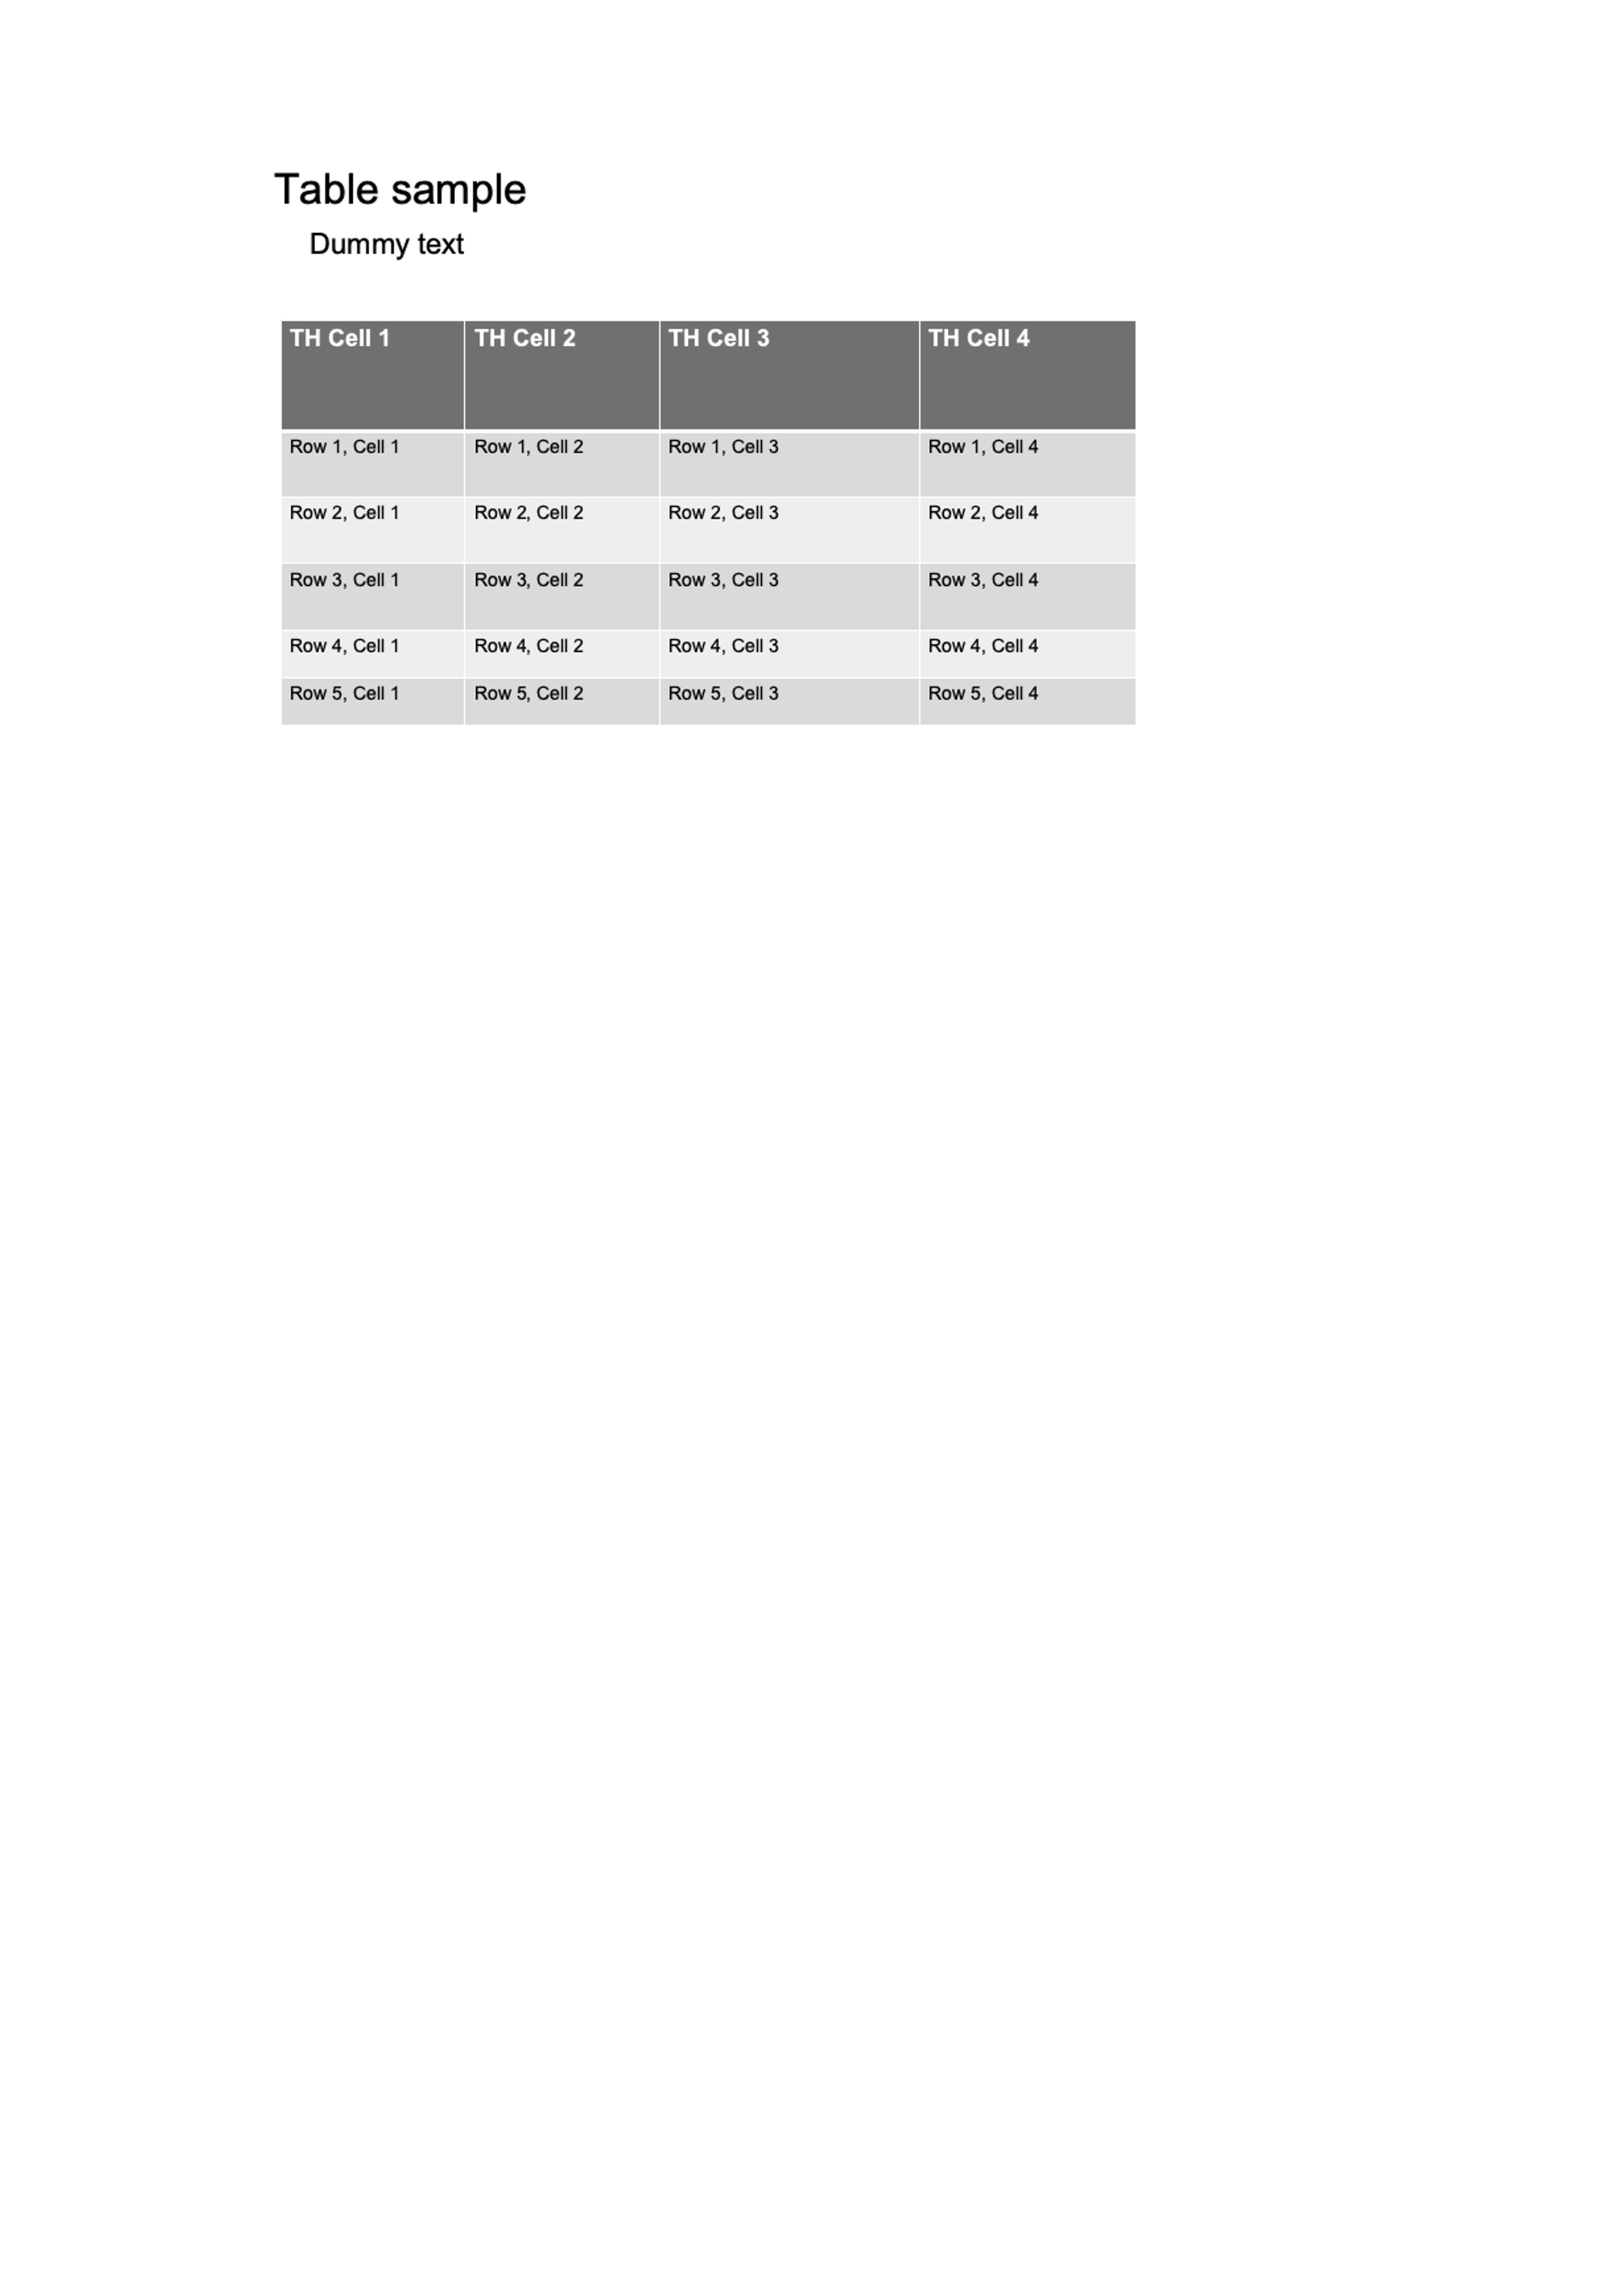

In [12]:
image_df = PptToPdf().setOutputCol("content").transform(ppt_example_df)
display_pdf(image_df)

## Extract tables from PPT using `PptToTextTable` transformer

In [39]:
ppt_to_table = PptToTextTable()
ppt_to_table.setInputCol("content")
ppt_to_table.setOutputCol("table")

result = ppt_to_table.transform(ppt_example_df).cache()

## Display result DataFrame

In [40]:
result.show()

+--------------------+-------------------+------+--------------------+---------+-------+
|                path|   modificationTime|length|               table|exception|pagenum|
+--------------------+-------------------+------+--------------------+---------+-------+
|file:/Users/nmeln...|2021-09-09 16:23:08|117248|[[0, 0, 30.0, 168...|     null|      0|
+--------------------+-------------------+------+--------------------+---------+-------+



In [42]:
display_tables(result)

Filename: 54111.ppt
Page:     0
Table:    0


,col0,col1,col2,col3
0,TH Cell 1,TH Cell 2,TH Cell 3,TH Cell 4
1,"Row 1, Cell 1","Row 1, Cell 2","Row 1, Cell 3","Row 1, Cell 4"
2,"Row 2, Cell 1","Row 2, Cell 2","Row 2, Cell 3","Row 2, Cell 4"
3,"Row 3, Cell 1","Row 3, Cell 2","Row 3, Cell 3","Row 3, Cell 4"
4,"Row 4, Cell 1","Row 4, Cell 2","Row 4, Cell 3","Row 4, Cell 4"
5,"Row 5, Cell 1","Row 5, Cell 2","Row 5, Cell 3","Row 5, Cell 4"


In [41]:
result.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- table: struct (nullable = true)
 |    |-- area: struct (nullable = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullable = false)
 |    |-- chunks: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- chunkText: string (nullable = false)
 |    |    |    |    |-- x: float (nullable = false)
 |    |    |    |    |-- y: float (nullable = false)
 |    |    |    |    |-- width: float (nullable = false)
 |    |    |    |    |-- height: float (null

## Display extracted data in JSON format

In [17]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 32.0,
            "y": 54.0,
            "width": 656.0,
            "height": 470.5,
            "score": 0.0,
            "label": "0"
        },
        "chunks": [
            [
                {
                    "chunkText": "Reaction",
                    "x": 32.0,
                    "y": 85.5,
                    "width": 200.0,
                    "height": 31.125
                },
                {
                    "chunkText": "Rate",
                    "x": 232.0,
                    "y": 85.5,
                    "width": 99.125,
                    "height": 31.125
                },
                null,
                {
                    "chunkText": "Units",
                    "x": 331.125,
                    "y": 85.5,
                    "width": 116.875,
                    "height": 31.125
                },
                {
                    "chunkT

In [ ]:
result.unpersist()

## Extract tables from PPTX using `PptToTextTable` transformer

In [43]:
pptx_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/ppt/54111.pptx')
pptx_example_df = spark.read.format("binaryFile").load(pptx_example)

pptx_result = ppt_to_table.transform(pptx_example_df).cache()
pptx_result.show()


+--------------------+-------------------+------+--------------------+---------+-------+
|                path|   modificationTime|length|               table|exception|pagenum|
+--------------------+-------------------+------+--------------------+---------+-------+
|file:/Users/nmeln...|2021-09-09 16:23:08| 43515|[[0, 0, 30.0, 168...|     null|      0|
+--------------------+-------------------+------+--------------------+---------+-------+



In [44]:
display_tables(pptx_result)

Filename: 54111.pptx
Page:     0
Table:    0


,col0,col1,col2,col3
0,TH Cell 1,TH Cell 2,TH Cell 3,TH Cell 4
1,"Row 1, Cell 1","Row 1, Cell 2","Row 1, Cell 3","Row 1, Cell 4"
2,"Row 2, Cell 1","Row 2, Cell 2","Row 2, Cell 3","Row 2, Cell 4"
3,"Row 3, Cell 1","Row 3, Cell 2","Row 3, Cell 3","Row 3, Cell 4"
4,"Row 4, Cell 1","Row 4, Cell 2","Row 4, Cell 3","Row 4, Cell 4"
5,"Row 5, Cell 1","Row 5, Cell 2","Row 5, Cell 3","Row 5, Cell 4"


In [ ]:
pptx_result.unpersist()